<a href="https://colab.research.google.com/github/NMashalov/FederationLearning/blob/master/Fed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reserach on zero-gradient in federation learning

Code was highly inspired by implementation in paper:

https://arxiv.org/pdf/2304.07861.pdf


First we'll work without samples
$$
    f(x,\xi) ={\left(<x,\xi> - \sum_{i=1}^d\xi_i\right) ^2}+ \|x\|_\infty + \delta
$$

$x \in R^d$

$\xi_i \sim U[0,1]$

$\delta \sim \mathbf{N(0,\sigma^2)}$

Optimization set:

$$
    D = \{|x|=1, x > 0\}
$$


Recall, infinity norm is max among all coordinates

$$
    \|x\|_\infty = \max\limits_{i=1,n} x_i
$$

## Algorithm implmentation

In [10]:
import numpy as np

In [11]:
### HYPERPARAMS
# vector dim
D = 20
# number of machines
M = 32
# smoothing gamma
G = 0.001
# number of samples
N = 50_000

In [12]:
# N x D matrix
X_train = np.random.uniform(size=(N,D))

In [13]:
def loss(x,xi, noise = 0):
    """
    Compute optimization function

    Argument:
        x: tensor [Machines number, Vector Dim]
        xi: tensor sample from []
        noise:
    """
    return (x @ xi.T - np.sum(xi,axis=1))**2  + np.max(x) + noise * np.random.randn(xi.shape[0])

Gradient approximation

Two points l1:
$$
\nabla f_\gamma (x, ξ, e) = \frac{d}{2γ}
\left(f_{δ1}
(x + γe, ξ) − f_{δ2}
(x − γe, ξ)\right) sign(e)
$$


Two points l2:
$$
\nabla f_\gamma (x, ξ, e) = \frac{d}{2γ}
\left(f_{δ1}
(x + γe, ξ) − f_{δ2}
(x − γe, ξ)\right) e
$$

In [14]:
def sample_spherical(ndim=D):
    vec = np.random.randn(ndim)
    vec /= np.linalg.norm(vec)
    return vec

In [15]:
import typing as tp

method_type = tp.Literal['l1','l2']

def calc_grad(x: np.array,xi: np.array, method_type: method_type = 'l2', noise=0):

    def loss(x,xi, noise = 0):
        """
        Compute optimization function

        Argument:
            x: tensor [Machines number, Vector Dim]
            xi: tensor sample from []
            noise:
        """
        return (x @ xi.T - np.sum(xi,axis=1))**2  + np.max(x) + noise * np.random.randn(xi.shape[0])


    if method_type == 'l2':
        e = sample_spherical()
        return D / (2* G) * np.mean((loss(x + G * e,xi) - loss(x - G * e,xi))) * e
    elif method_type == 'l1':
        raise NotImplementedError('l1')
    else:
        raise NotImplementedError('No methods')

## Minibatch SGD

In [16]:
def sample_grad(x,batch_size, noise):
    samples_idx = np.random.choice(N, batch_size, replace=True)
    X_sampled = X_train[samples_idx, :]
    return calc_grad(x,X_sampled,noise=noise)

In [17]:
def population_loss(x):
    """
    Compute the population loss for all training samples.

    Argument:
        weight: w
    """
    return np.mean(loss(x, X_train))

In [18]:
import pandas as pd
T = 10_00 # total number of computations = x2 oracle calls
K = 10 # sync interval

eta = 1e-3
beta = 2
alpha = 2
gamma = 0.1

local_batch = 10
record_intvl = 100

exp_num = 100

noise_level = [0,1, 10]

seqs = {}
def learning_curve(noise):
    w = np.random.randn(D)
    w_ag = np.copy(w)
    seq = pd.Series(name='loss')
    for iter_cnt in range(0, T+1, K):
        if iter_cnt % record_intvl == 0:
            seq.at[iter_cnt] = population_loss(w_ag)
        w_md = (1/beta) * w + (1-(1/beta))*w_ag
        grad_md = sample_grad(w_md, M*K*local_batch,noise)
        w_ag = w_md - eta * grad_md
        w = (1 - (1/alpha)) * w + (1/alpha) * \
            w_md - gamma * grad_md
    return seq


for noise in noise_level:
    seqs[noise] = []
    [seqs[noise].append(learning_curve(noise)) for i in range(exp_num)]

<ipython-input-18-3e3f2f85b60d>:21: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  seq = pd.Series(name='loss')
<ipython-input-18-3e3f2f85b60d>:21: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  seq = pd.Series(name='loss')
<ipython-input-18-3e3f2f85b60d>:21: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  seq = pd.Series(name='loss')
<ipython-input-18-3e3f2f85b60d>:21: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  seq = pd.Series(name='loss')
<ipython-input-18-3e3f2f85b60d>:21: FutureWarning: The default dtype for empty Series wi

$$
\sigma
$$

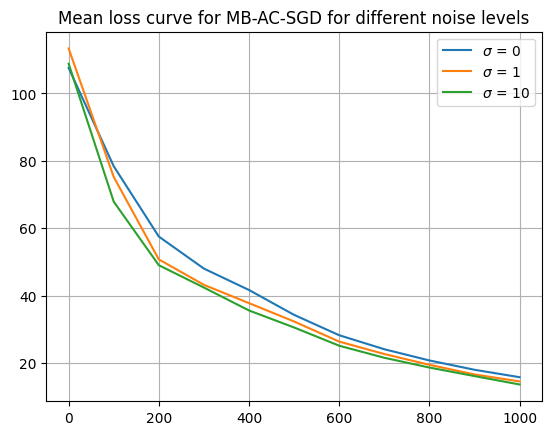

In [20]:
import matplotlib.pyplot as plt
[(sum(seqs)/exp_num).plot(label=r'$\sigma$ = {}'.format(n)) for n,seqs in seqs.items()]
plt.title('Mean loss curve for MB-AC-SGD for different noise levels')
plt.grid()
plt.legend()
plt.show()

## FED_AVG

In [ ]:
def broadcast_avg(pool):
    """
    Helper functions for FedAc and FedAvg, average and broadcast the weights.
    """
    avg = pool.mean(axis=0)
    pool = np.repeat(avg[np.newaxis, :], pool.shape[0], axis=0)
    return pool

In [ ]:
import pandas as pd
def fedavg(eta, M, K, T,  record_intvl=512, print_intvl=8192, SEED=0):
        """
        Simulate Federated Averaging (FedAvg, a.k.a. Local-SGD, or Parallel SGD, etc.)

        Arguments:
            eta:    learning rate
            M:      number of workers
            K:      synchronization interval, (i.e., local steps)
            T:      total parallel runtime
            record_intvl:   compute the population loss every record_intvl steps.

        Return:
            A pandas.Series object of population loss evaluated.
        """
        # set of
        np.random.seed(SEED)
        # weights on nodes
        common_init_w = np.random.randn(D)
        #
        w_pool = np.repeat(common_init_w[np.newaxis, :], M, axis=0)

        seq = pd.Series(name='loss')
        for iter_cnt in range(T+1):
            if iter_cnt % K == 0:
                w_pool = broadcast_avg(w_pool)

                if iter_cnt % record_intvl == 0:
                    seq.at[iter_cnt] = loss(w_pool[0, :])

            w_pool -= eta * calc_grad
        return seq

In [ ]:
calc_grad()

TypeError: ignored

## Smooth function